In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import shap

In [50]:
df = pd.read_csv('hackathon_imputed_converted_to_numerical.csv', sep=';')
df.drop([])
df_data = df.iloc[:, 1:-5]
df_target = df.iloc[:, -5:]

In [51]:
df_target.describe()

,Target: Артериальная гипертензия,Target: ОНМК,"Target: Стенокардия, ИБС, инфаркт миокарда",Target: Сердечная недостаточность,Target: Прочие заболевания сердца
count,1598.000000,1598.000000,1598.000000,1598.000000,1598.000000
mean,0.471840,0.041927,0.123279,0.093867,0.085732
std,0.499363,0.200486,0.328860,0.291735,0.280056
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [52]:
x_train, x_validation, y_train, y_validation = train_test_split(df_data, df_target, train_size=0.75, random_state=42)

In [63]:
models = {}
for name in df_target.columns:
    print(f'Column name {name}')
    t = df_target[name].values
    model = CatBoostClassifier(
        depth=3,
        task_type="GPU",
        class_weights=[1/ (t.shape[0] - t.sum()), 1 / t.sum()],
        custom_loss=['F1'],
        random_seed=42,
        logging_level='Silent')
    
    tr_data = Pool(x_train.values, y_train[name].values)
    ts_data = Pool(x_validation.values, y_validation[name].values)
    model.fit(tr_data, eval_set=ts_data, plot=False);
    model.save_model(f'{name}.cbm')
    eval_metrics = model.eval_metrics(ts_data, ['Accuracy', 'Precision', 'Recall'], plot=False)
    print({k:v[-1] for k, v in eval_metrics.items()})
    models[name] = model

Column name Target: Артериальная гипертензия
{'Accuracy': 0.7356798091119071, 'Precision': 0.7400911855915311, 'Recall': 0.7474226804123711}
Column name Target: ОНМК
{'Accuracy': 0.6035044653251533, 'Precision': 0.7655000031973459, 'Recall': 0.3684210526315789}
Column name Target: Стенокардия, ИБС, инфаркт миокарда
{'Accuracy': 0.6182611174696448, 'Precision': 0.6711328514771401, 'Recall': 0.5789473684210527}
Column name Target: Сердечная недостаточность
{'Accuracy': 0.6724818638106914, 'Precision': 0.6343135727600305, 'Recall': 0.696969696969697}
Column name Target: Прочие заболевания сердца
{'Accuracy': 0.5846557715238667, 'Precision': 0.6530095255064391, 'Recall': 0.35294117647058826}


Target: Артериальная гипертензия


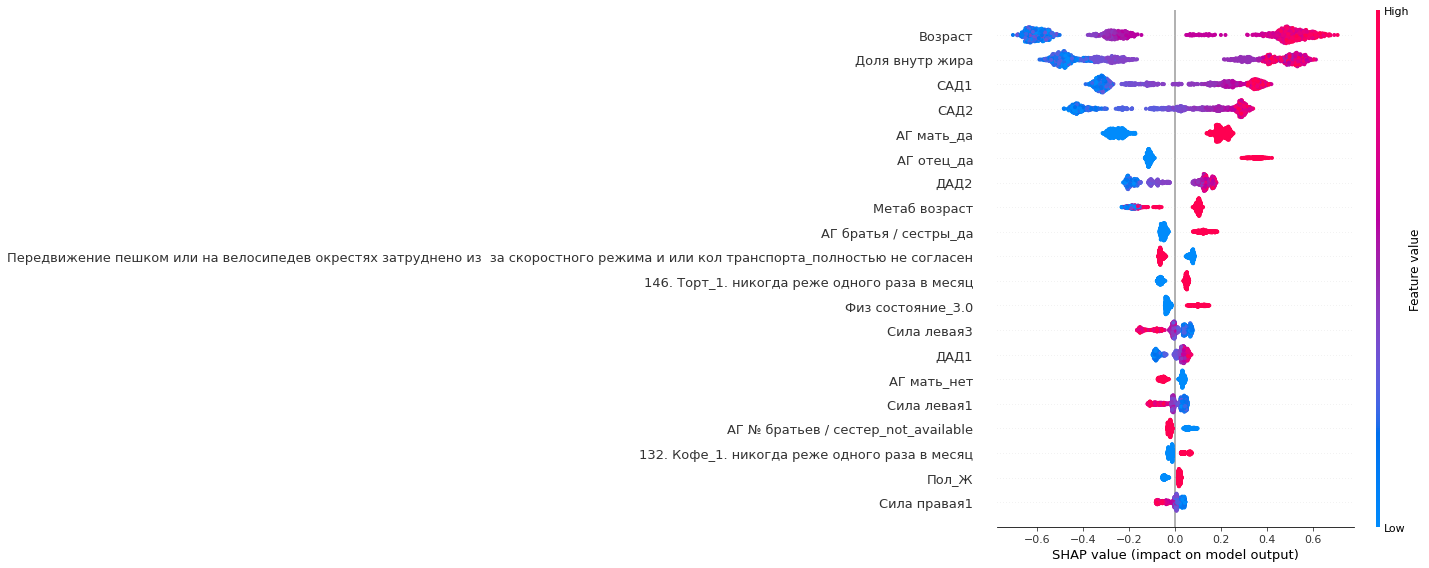

Target: ОНМК


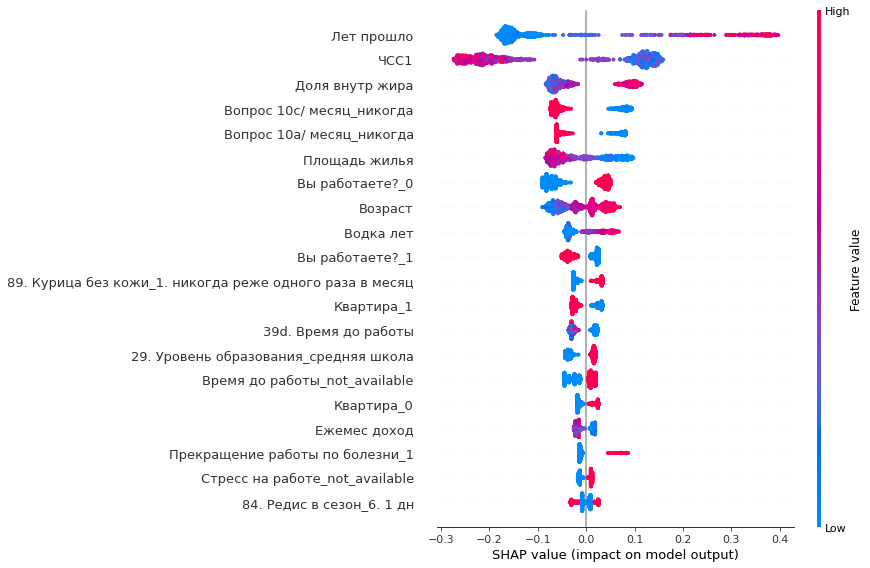

Target: Стенокардия, ИБС, инфаркт миокарда


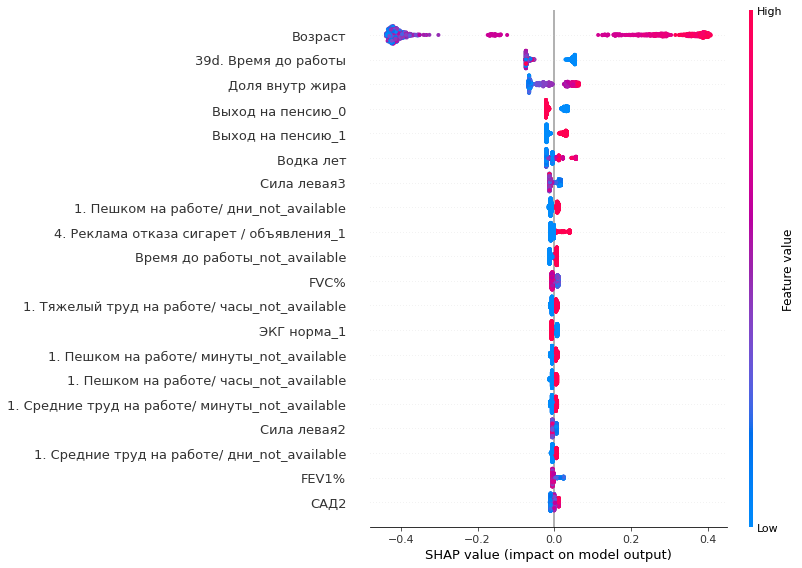

Target: Сердечная недостаточность


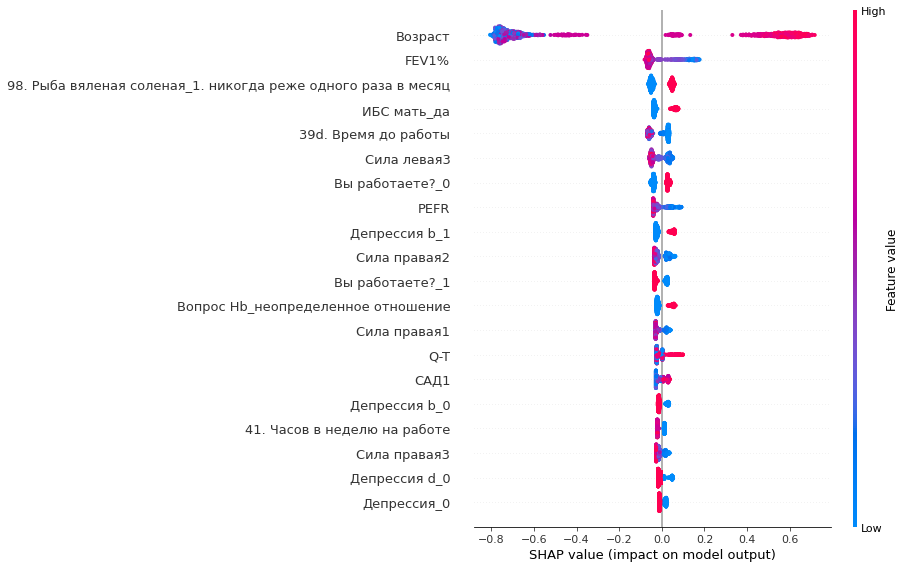

Target: Прочие заболевания сердца


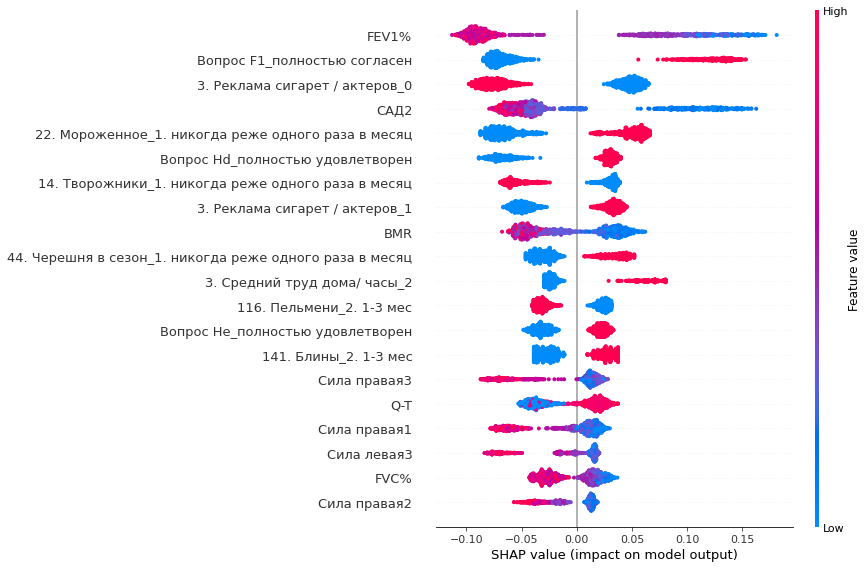

In [64]:
for name, model in models.items():
    print(name)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_train)
    # summarize the effects of all the features
    shap.summary_plot(shap_values, x_train)